In [213]:
# Importing the required libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

import pennylane as qml
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import gc

# Set random seed for reproducibility
np.random.seed(42)

In [214]:
# Load Dataset
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [215]:
# Filter TLS-related traffic
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[(darknet_data['Dst Port'].isin(tls_ports)) & (darknet_data['Protocol'] == 6)]

In [216]:
# Ensure tls_traffic is a separate DataFrame to avoid SettingWithCopyWarning
tls_traffic = tls_traffic.copy()

# Encode categorical data safely
label_encoder = LabelEncoder()
for column in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic[column] = label_encoder.fit_transform(tls_traffic[column])


In [217]:
# Ensure tls_traffic is a separate DataFrame
tls_traffic = tls_traffic.copy()

# Select Numeric Columns
columns_to_exclude = ['Protocol', 'Dst Port', 'Label']
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Optimize Memory
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].astype(np.float32)
gc.collect()

15610

In [218]:
# Ensure tls_traffic is a separate DataFrame to avoid modifying a view
tls_traffic = tls_traffic.copy()

# Handle Missing & Extreme Values
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].clip(
    lower=tls_traffic[numeric_columns].quantile(0.01),
    upper=tls_traffic[numeric_columns].quantile(0.99),
    axis=1
)

# Apply MinMax Scaling
tls_traffic[numeric_columns] = MinMaxScaler().fit_transform(tls_traffic[numeric_columns])

# **Feature Selection and Feature Importance**

Timestamp feature removed after feature selection!
Selected Features Based on Correlation with 'Label':
Timestamp               -0.300921
Total Bwd packets        0.151538
Bwd Packet Length Min    0.153685
Fwd Header Length        0.148203
Bwd Header Length        0.159089
Bwd Packets/s           -0.145038
SYN Flag Count          -0.181020
PSH Flag Count           0.140459
ACK Flag Count           0.146736
FWD Init Win Bytes       0.295387
Bwd Init Win Bytes       0.269703
Fwd Seg Size Min         0.754784
Name: Label, dtype: float64


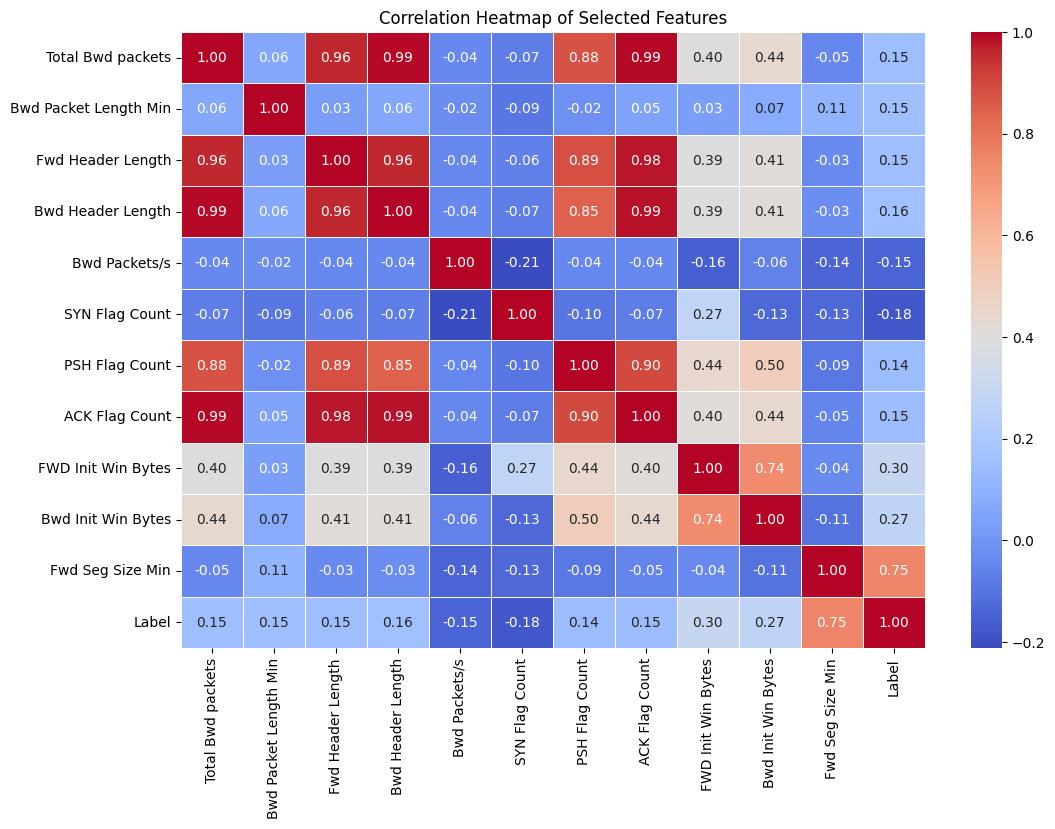

In [219]:
# Feature Selection Process (Newly Added)
correlation_matrix = tls_traffic.corr(numeric_only=True)
target_correlation = correlation_matrix['Label'].drop('Label')
threshold = 0.14  # Selecting features with absolute correlation > 0.14
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns if they exist
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Keep only the selected features and the Label
tls_traffic = tls_traffic[selected_features.index.tolist() + ['Label']]
if 'Timestamp' in tls_traffic.columns:
    tls_traffic = tls_traffic.drop(columns=['Timestamp'])
    print("Timestamp feature removed after feature selection!")

print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Generate correlation heatmap for the selected features
plt.figure(figsize=(12, 8))
sns.heatmap(tls_traffic.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()


In [220]:
# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)
tls_traffic = pd.DataFrame(X, columns=X.columns)
tls_traffic['Label'] = y
gc.collect()

15714

In [221]:
# One-Hot Encode the 'Label' column
ohe = OneHotEncoder(sparse_output=False)  # Use dense output instead of sparse matrix
y_encoded = ohe.fit_transform(tls_traffic[['Label']])  # Encode the label column

# Convert to DataFrame with proper column names
ohe_columns = [f"Class_{i}" for i in range(y_encoded.shape[1])]
y_encoded_df = pd.DataFrame(y_encoded, columns=ohe_columns)

# Keep original 'Label' column while adding one-hot encoded versions
tls_traffic = pd.concat([tls_traffic, y_encoded_df], axis=1)

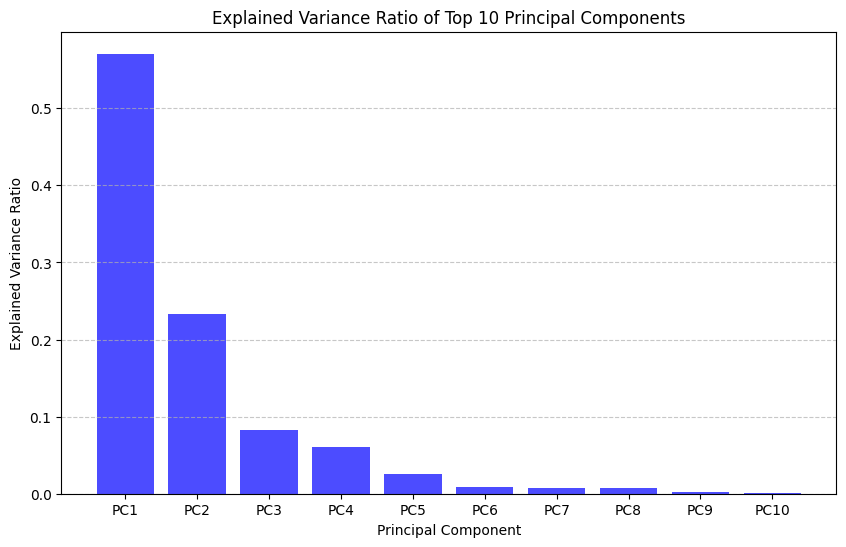

In [222]:
# Apply PCA
pca = PCA(n_components=10)  # Select the top 10 principal components
X_pca = pca.fit_transform(X)  # Fit PCA on the dataset

# Convert to DataFrame with proper column names
X_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(10)])

# Generate the explained variance ratio plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color="blue")
plt.xticks(range(1, 11), [f"PC{i}" for i in range(1, 11)])
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.title("Explained Variance Ratio of Top 10 Principal Components")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [223]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# **Qiskit Device and Quantum Circuit Intialization**

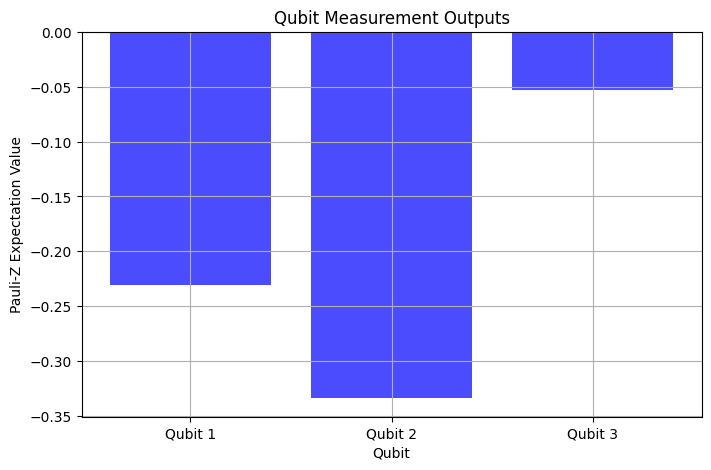

In [224]:
# Split for quantum & classical inputs
num_qubits = 3

# First 3 features for Quantum
quantum_features = X_train.iloc[:, :num_qubits]  

# Remaining for Classical features alone
classical_features = X_train.iloc[:, num_qubits:]  

# Define Quantum Circuit
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Run the circuit to get expectation values
expectation_values = quantum_circuit(sample_input, sample_weights)

# Plot expectation values
plt.figure(figsize=(8, 5))
plt.bar(range(len(expectation_values)), expectation_values, color="blue", alpha=0.7)
plt.xlabel("Qubit")
plt.ylabel("Pauli-Z Expectation Value")
plt.title("Qubit Measurement Outputs")
plt.xticks(range(len(expectation_values)), [f"Qubit {i+1}" for i in range(len(expectation_values))])
plt.grid()
plt.show()

# **Hybrid Quantum-Classical Neural Network**

In [225]:
# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(name="q_weights", shape=(1, num_qubits), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        return tf.random.uniform((tf.shape(inputs)[0], self.num_qubits))

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

# Define Hybrid Model
def create_hybrid_model(num_qubits, num_features, num_classes=4):
    input_q = tf.keras.layers.Input(shape=(num_qubits,))
    input_c = tf.keras.layers.Input(shape=(num_features - num_qubits,))
    
    # Quantum Path
    q_layer = QuantumLayer(num_qubits)(input_q)
    q_layer = tf.keras.layers.Dense(32, activation="relu")(q_layer)

    # Classical Path
    # Reduce neurons & increase dropout
    c_layer = tf.keras.layers.Dense(64, activation="relu")(input_c)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.3)(c_layer)
    c_layer = tf.keras.layers.Dense(32, activation="relu")(c_layer)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.3)(c_layer)

    
    # Fusion of Quantum & Classical Features
    combined = tf.keras.layers.concatenate([q_layer, c_layer])
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(combined)

    model = tf.keras.models.Model(inputs=[input_q, input_c], outputs=output)
    return model

In [226]:
hybrid_model = create_hybrid_model(num_qubits, X_train.shape[1])
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="categorical_crossentropy",
                     metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

In [227]:
# Split Training & Validation Data
X_train_q, X_val_q, X_train_c, X_val_c, y_train_split, y_val_split = train_test_split(
    quantum_features, classical_features, to_categorical(y_train, num_classes=4),
    test_size=0.2, random_state=42, stratify=y_train
)

In [228]:
# Define Custom Data Generator
class CustomBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_q, X_c, y, batch_size):
        self.X_q = X_q
        self.X_c = X_c
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_X_q = self.X_q[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_c = self.X_c[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X_q, batch_X_c], batch_y

train_generator = CustomBatchGenerator(X_train_q, X_train_c, y_train_split, batch_size=32)
val_generator = CustomBatchGenerator(X_val_q, X_val_c, y_val_split, batch_size=32)

In [229]:
# Train the Model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    verbose=1
)

Epoch 1/100
912/912 [==============================] - 2s 1ms/step - loss: 0.3791 - accuracy: 0.8772 - precision: 0.9146 - recall: 0.8377 - val_loss: 0.0703 - val_accuracy: 0.9848 - val_precision: 0.9871 - val_recall: 0.9737
Epoch 2/100
912/912 [==============================] - 1s 1ms/step - loss: 0.1190 - accuracy: 0.9627 - precision: 0.9680 - recall: 0.9582 - val_loss: 0.0217 - val_accuracy: 0.9923 - val_precision: 0.9929 - val_recall: 0.9919
Epoch 3/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0717 - accuracy: 0.9777 - precision: 0.9804 - recall: 0.9756 - val_loss: 0.0101 - val_accuracy: 0.9982 - val_precision: 0.9982 - val_recall: 0.9982
Epoch 4/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0529 - accuracy: 0.9829 - precision: 0.9842 - recall: 0.9815 - val_loss: 0.0073 - val_accuracy: 0.9985 - val_precision: 0.9985 - val_recall: 0.9985
Epoch 5/100
912/912 [==============================] - 1s 1ms/step - loss: 0.0422 - accuracy: 0.9864

In [230]:
# Predict Malicious TLS Traffic
y_pred_probs = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract Malicious Traffic
malicious_traffic = X_test.iloc[np.where(y_pred == 0)].copy()
malicious_traffic['Predicted_Label'] = y_pred[np.where(y_pred == 0)]

# Save Malicious TLS Traffic to CSV
malicious_traffic.to_csv("Malicious_TLS_Traffic.csv", index=False)
print(f"Saved {len(malicious_traffic)} malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.")

285/285 [==============================] - 0s 533us/step
Saved 2279 malicious TLS traffic records to 'Malicious_TLS_Traffic.csv'.


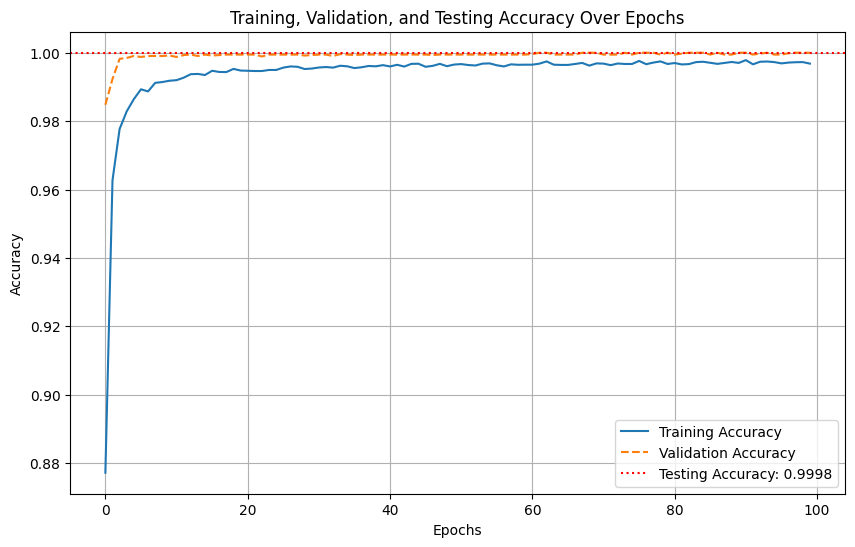

In [231]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='solid')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')

# Calculate Testing Accuracy
test_accuracy = np.mean(y_pred == y_test)
plt.axhline(y=test_accuracy, color='r', linestyle='dotted', label=f'Testing Accuracy: {test_accuracy:.4f}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Testing Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

285/285 [==============================] - 0s 535us/step


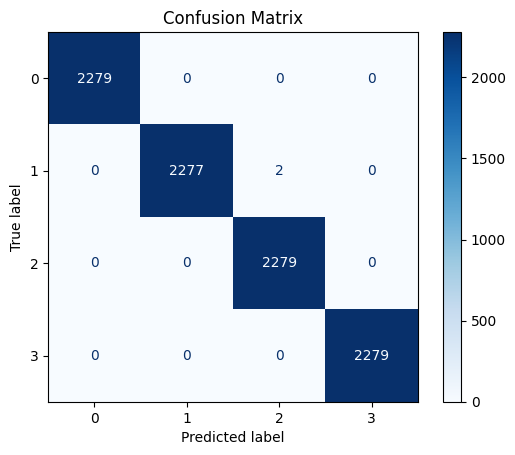

In [232]:
# Predict labels for the test set
y_pred = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.array(y_test)  # True labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [233]:
# Debugging: Check if 'Label' exists
print("Columns in dataset:", tls_traffic.columns)

Columns in dataset: Index(['Total Bwd packets', 'Bwd Packet Length Min', 'Fwd Header Length',
       'Bwd Header Length', 'Bwd Packets/s', 'SYN Flag Count',
       'PSH Flag Count', 'ACK Flag Count', 'FWD Init Win Bytes',
       'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Label', 'Class_0', 'Class_1',
       'Class_2', 'Class_3'],
      dtype='object')


In [234]:
# Shuffle the dataset before selecting a random sample
tls_traffic = tls_traffic.sample(frac=1).reset_index(drop=True)  # Ensures different selections each run

# Identify label columns (Both One-Hot Encoded and Original)
label_columns = [col for col in tls_traffic.columns if "Class_" in col]  # OHE labels
original_label_column = "Label" if "Label" in tls_traffic.columns else None

# Load a Truly Random TLS Traffic Sample (No Fixed Random State)
random_sample = tls_traffic.sample(1)

# Extract the true label
true_label = random_sample[original_label_column].values[0]  # Keep the original label

# Drop One-Hot Encoded label columns but KEEP original Label
random_sample = random_sample.drop(columns=label_columns)  

# Ensure Feature Alignment - Reorder Columns as in Training
random_sample = random_sample.reindex(columns=X.columns, fill_value=0)  # Ensures all features match PCA input

# Apply the Same Preprocessing as Training Data
scaler = MinMaxScaler().fit(X)  # Fit scaler on full training data
random_sample_scaled = scaler.transform(random_sample)  # Normalize

# Apply PCA
random_sample_pca = pca.transform(random_sample_scaled)  # Apply PCA

# Split into Quantum & Classical Inputs
random_sample_q = random_sample_pca[:, :num_qubits]  # First 3 PCA components
random_sample_c = random_sample_pca[:, num_qubits:]  # Remaining components

# Reshape for Prediction
random_sample_q = random_sample_q.reshape(1, -1)
random_sample_c = random_sample_c.reshape(1, -1)

# Display the Random TLS Traffic Sample Before Prediction
print("\n===== Random TLS Traffic Sample (Before Processing) =====")
display(pd.DataFrame(random_sample))  # Display the sample in a readable table

# Display the Scaled Data
print("\n===== Random TLS Traffic Sample (After Scaling) =====")
display(pd.DataFrame(random_sample_scaled, columns=X.columns))

# Display the PCA Transformed Data
print("\n===== Random TLS Traffic Sample (After PCA) =====")
display(pd.DataFrame(random_sample_pca, columns=[f"PCA_{i+1}" for i in range(random_sample_pca.shape[1])]))

# Display Quantum and Classical Features Separately
print("\n===== Quantum Features Passed to Model =====")
display(pd.DataFrame(random_sample_q, columns=[f"Q_{i+1}" for i in range(num_qubits)]))

print("\n===== Classical Features Passed to Model =====")
display(pd.DataFrame(random_sample_c, columns=[f"C_{i+1}" for i in range(random_sample_c.shape[1])]))

# Predict Using the Model
pred_prob = hybrid_model.predict([random_sample_q, random_sample_c])
pred_label = np.argmax(pred_prob, axis=1)[0]

# Define Labels (Assuming 0 = Malicious, 1 = Non-Malicious, 2 & 3 = Uncertain)
labels_dict = {0: "Malicious", 1: "Non-Malicious", 2: "Uncertain"}

# Display Prediction
print("\n===== Random TLS Traffic Prediction =====")
print(f"Predicted Label: {labels_dict[pred_label]}")
print(f"True Label: {'Malicious' if true_label == 0 else 'Non-Malicious'}")


===== Random TLS Traffic Sample (Before Processing) =====


c:\Users\Nirusan03\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


,Total Bwd packets,Bwd Packet Length Min,Fwd Header Length,Bwd Header Length,Bwd Packets/s,SYN Flag Count,PSH Flag Count,ACK Flag Count,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Label
45566,0.002636,0.0,0.003611,0.002337,0.000024,0.0,0.003744,0.003149,0.036919,0.040284,0.0,0



===== Random TLS Traffic Sample (After Scaling) =====


,Total Bwd packets,Bwd Packet Length Min,Fwd Header Length,Bwd Header Length,Bwd Packets/s,SYN Flag Count,PSH Flag Count,ACK Flag Count,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Seg Size Min,Label
0,0.002636,0.0,0.003611,0.002337,0.000024,0.0,0.003744,0.003149,0.036919,0.040284,0.0,0.0



===== Random TLS Traffic Sample (After PCA) =====


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,-1.57085,-0.012803,-0.464367,-0.089438,-0.13481,-0.000608,-0.001234,-0.09543,0.008578,0.002685



===== Quantum Features Passed to Model =====


,Q_1,Q_2,Q_3
0,-1.57085,-0.012803,-0.464367



===== Classical Features Passed to Model =====


,C_1,C_2,C_3,C_4,C_5,C_6,C_7
0,-0.089438,-0.13481,-0.000608,-0.001234,-0.09543,0.008578,0.002685


1/1 [==============================] - 0s 61ms/step

===== Random TLS Traffic Prediction =====
Predicted Label: Malicious
True Label: Malicious
